## 1. Libraries and dara import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer,make_column_transformer
from sklearn.pipeline import Pipeline,make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_score, train_test_split,GridSearchCV,StratifiedKFold

In [2]:
train = pd.read_csv("train.csv")

test = pd.read_csv("test.csv")

In [3]:
train.head(6)

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   
5            6         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   
5                                   Moran, Mr. James    male   NaN      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
5      0            330877   8.4583   NaN        Q

## 2. Data exploration and preaparation

In [4]:
train.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

In [5]:
train.describe(include=['O'])

Name   Sex  Ticket    Cabin Embarked
count                       891   891     891      204      889
unique                      891     2     681      147        3
top     Braund, Mr. Owen Harris  male  347082  B96 B98        S
freq                          1   577       7        4      644

In [6]:
train.groupby(["Pclass"],as_index=False)["Survived"].mean()

Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363

In [7]:
train.groupby(["Parch"],as_index=False)["Survived"].mean()

Parch  Survived
0      0  0.343658
1      1  0.550847
2      2  0.500000
3      3  0.600000
4      4  0.000000
5      5  0.200000
6      6  0.000000

In [8]:
train.groupby(["Sex"],as_index=False)["Survived"].mean()

Sex  Survived
0  female  0.742038
1    male  0.188908

In [9]:
train.groupby(["SibSp"],as_index=False)["Survived"].mean()

SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000

Create family size feature.

In [10]:
train["Family"]=train["Parch"]+train["SibSp"]+1

test["Family"]=test["Parch"]+test["SibSp"]+1

In [11]:
train.groupby(["Family"],as_index=False)["Survived"].mean()

Family  Survived
0       1  0.303538
1       2  0.552795
2       3  0.578431
3       4  0.724138
4       5  0.200000
5       6  0.136364
6       7  0.333333
7       8  0.000000
8      11  0.000000

In [12]:
train.groupby(["Embarked"],as_index=False)["Survived"].mean()

Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.336957

Age distribution

In [13]:
sns.displot(train,x="Age",col="Survived",kde=True)

Fare distribution

In [14]:
sns.displot(train,x="Fare",col="Survived",binwidth=30,height=5,kde=True)

Here I'm trying to get the Title and simplify it to class that title is belong to.

In [15]:
train['Name']

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

In [16]:
train["Title"]=train["Name"].str.split(pat=',',expand=True)[1].str.split(pat='.',expand=True)[0].apply(lambda x:x.strip())

test["Title"]=test["Name"].str.split(pat=',',expand=True)[1].str.split(pat='.',expand=True)[0].apply(lambda x:x.strip())

In [17]:
train.groupby(["Title"],as_index=False)["Survived"].mean()

Title  Survived
0           Capt  0.000000
1            Col  0.500000
2            Don  0.000000
3             Dr  0.428571
4       Jonkheer  0.000000
5           Lady  1.000000
6          Major  0.500000
7         Master  0.575000
8           Miss  0.697802
9           Mlle  1.000000
10           Mme  1.000000
11            Mr  0.156673
12           Mrs  0.792000
13            Ms  1.000000
14           Rev  0.000000
15           Sir  1.000000
16  the Countess  1.000000

Military: Capt, Col, Major
Noble: Jonkheer, the Countess, Don, Lady, Sir
Unmarried women: Mlle, Miss, Mme

In [18]:
train["Title"]=train["Title"].replace({
    "Capt": "Military",
    "Col":"Military",
    "Major":"Military",
    "Jonkheer":"Noble",
    "the Countess":"Noble",
    "Don":"Noble",
    "Lady":"Noble",
    "Sir":"Noble",
    "Mlle": "Unmarried women",
    "Miss":"Unmarried women",
    "Mme":"Unmarried women"
})

In [19]:
train.groupby(["Title"],as_index=False)["Survived"].agg(["mean","count"])

Title      mean  count
0               Dr  0.428571      7
1           Master  0.575000     40
2         Military  0.400000      5
3               Mr  0.156673    517
4              Mrs  0.792000    125
5               Ms  1.000000      1
6            Noble  0.600000      5
7              Rev  0.000000      6
8  Unmarried women  0.702703    185

Some interesting pattern)

In [20]:
train["Name_Length"]=train["Name"].apply(lambda x:len(x))

test["Name_Length"]=test["Name"].apply(lambda x:len(x))

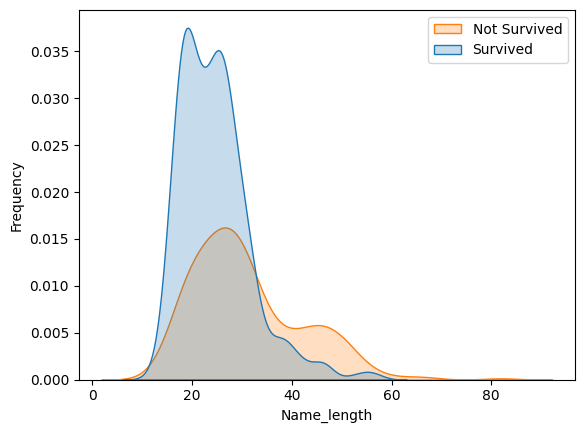

In [21]:
g=sns.kdeplot(train[train["Name_Length"].notnull()],x="Name_Length",hue="Survived",fill=True)
g.set_xlabel("Name_length")
g.set_ylabel("Frequency")
g=g.legend(['Not Survived','Survived'])

Here I'm trying to get ticket number,count people who has the same ticket number(I think may be they lived together) and trying to get the location of their cabin from ticket.

In [22]:
train["Ticket_Number"]=train["Ticket"].apply(lambda x: pd.Series({'Ticket':x.split()[-1]}))

test["Ticket_Number"]=test["Ticket"].apply(lambda x: pd.Series({'Ticket':x.split()[-1]}))

In [23]:
train.groupby(["Ticket_Number"],as_index=False)['Survived'].agg(['mean','count']).sort_values('count')

Ticket_Number      mean  count
0           10482  1.000000      1
428        345364  0.000000      1
429        345572  1.000000      1
430        345763  0.000000      1
432        345765  0.000000      1
..            ...       ...    ...
168          2144  0.000000      6
468        347088  0.000000      6
464        347082  0.000000      7
196          2343  0.000000      7
94           1601  0.714286      7

[679 rows x 3 columns]

In [24]:
train["Ticket_Number_Counts"]=train.groupby("Ticket_Number")["Ticket_Number"].transform('count')
test["Ticket_Number_Counts"]=test.groupby("Ticket_Number")["Ticket_Number"].transform('count')

In [25]:
train.groupby(["Ticket_Number_Counts"],as_index=False)['Survived'].agg(['mean','count']).sort_values('count')

Ticket_Number_Counts      mean  count
4                     5  0.000000     10
5                     6  0.000000     18
6                     7  0.238095     21
3                     4  0.500000     44
2                     3  0.712121     66
1                     2  0.569149    188
0                     1  0.295956    544

In [26]:
train['Ticket_loc']=np.where(train['Ticket'].str.split(pat=' ',expand=True)[1].notna(),train['Ticket'].str.split(pat=' ',expand=True)[0].apply(lambda x:x.strip()),'no')
test['Ticket_loc']=np.where(test['Ticket'].str.split(pat=' ',expand=True)[1].notna(),test['Ticket'].str.split(pat=' ',expand=True)[0].apply(lambda x:x.strip()),'no')

In [27]:
train['Ticket_loc'].value_counts()

Ticket_loc
no            665
PC             60
C.A.           27
STON/O         12
A/5            10
W./C.           9
CA.             8
SOTON/O.Q.      8
SOTON/OQ        7
A/5.            7
CA              6
STON/O2.        6
C               5
F.C.C.          5
S.O.C.          5
SC/PARIS        5
SC/Paris        4
S.O./P.P.       3
PP              3
A/4.            3
A/4             3
SC/AH           3
A./5.           2
SOTON/O2        2
A.5.            2
WE/P            2
S.C./PARIS      2
P/PP            2
F.C.            1
SC              1
S.W./PP         1
A/S             1
Fa              1
SCO/W           1
SW/PP           1
W/C             1
S.C./A.4.       1
S.O.P.          1
A4.             1
W.E.P.          1
SO/C            1
S.P.            1
C.A./SOTON      1
Name: count, dtype: int64

It's kinda "dirty", so lets delete some symbols.

In [28]:
train["Ticket_loc"]=train["Ticket_loc"].apply(lambda x:str(x).upper().replace('.','').replace('/',''))
test["Ticket_loc"]=test["Ticket_loc"].apply(lambda x:str(x).upper().replace('.','').replace('/',''))

In [29]:
train.groupby(["Ticket_loc"],as_index=False)["Survived"].agg(['mean','count'])

Ticket_loc      mean  count
0          A4  0.000000      7
1          A5  0.095238     21
2          AS  0.000000      1
3           C  0.400000      5
4          CA  0.341463     41
5     CASOTON  0.000000      1
6          FA  0.000000      1
7          FC  0.000000      1
8         FCC  0.800000      5
9          NO  0.383459    665
10         PC  0.650000     60
11         PP  0.666667      3
12        PPP  0.500000      2
13         SC  1.000000      1
14       SCA4  0.000000      1
15       SCAH  0.666667      3
16       SCOW  0.000000      1
17    SCPARIS  0.454545     11
18        SOC  0.166667      6
19        SOP  0.000000      1
20       SOPP  0.000000      3
21    SOTONO2  0.000000      2
22    SOTONOQ  0.133333     15
23         SP  0.000000      1
24      STONO  0.416667     12
25     STONO2  0.500000      6
26       SWPP  1.000000      2
27         WC  0.100000     10
28        WEP  0.333333      3

Getting the Сabin class

In [30]:
train["Cabin"]=train["Cabin"].fillna("U")
train["Cabin"]=pd.Series([i[0] if not pd.isnull(i) else 'x' for i in train["Cabin"]])

test["Cabin"]=test["Cabin"].fillna("U")
test["Cabin"]=pd.Series([i[0] if not pd.isnull(i) else 'x' for i in test["Cabin"]])

In [31]:
train.groupby(["Cabin"],as_index=False)["Survived"].agg(['mean','count'])

Cabin      mean  count
0     A  0.466667     15
1     B  0.744681     47
2     C  0.593220     59
3     D  0.757576     33
4     E  0.750000     32
5     F  0.615385     13
6     G  0.500000      4
7     T  0.000000      1
8     U  0.299854    687

In [32]:
train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  Family            Title  \
0      0         A/5 21171   7.2500     U        S       2               Mr   
1      0          PC 17599  71.2833     C        C       2              Mrs   
2      0  STON/O2. 3101282   7.9250     U        S       1  Unmarried women   
3      0            113803  53.1000     C        S       2              Mrs   
4      0            373450   8.0500     U        S       1               Mr   

   Name_Length Ticket_Number  Ticket_Number_Counts Ticket_loc  
0           23         21171                     1         A5  
1           51         17599                     1         PC  
2           22       3101282                     1     STONO2  
3           44        113803                     2         NO  
4           24        373450                     1         NO

Some correlations

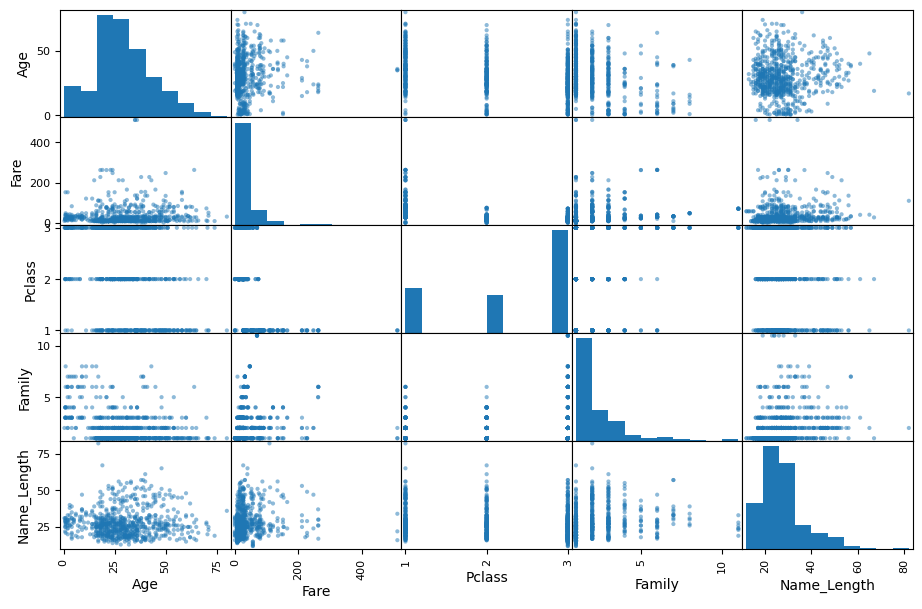

In [33]:
atr=['Age','Fare','Pclass','Family','Name_Length']

scatter_matrix(train[atr],figsize=(11,7))
plt.show()

In [34]:
plt.figure(figsize=(10,7))
sns.heatmap(train.corr(numeric_only=True),annot=True,cmap="coolwarm",fmt='.2f')

<Axes: >

We see strong correllation between family and SibSp,Parch. Let's drop them and keep Family instead.

## 3.Pipeline

In [35]:
train.shape

(891, 18)

In [36]:
test.shape

(418, 17)

In [37]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PassengerId           891 non-null    int64  
 1   Survived              891 non-null    int64  
 2   Pclass                891 non-null    int64  
 3   Name                  891 non-null    object 
 4   Sex                   891 non-null    object 
 5   Age                   714 non-null    float64
 6   SibSp                 891 non-null    int64  
 7   Parch                 891 non-null    int64  
 8   Ticket                891 non-null    object 
 9   Fare                  891 non-null    float64
 10  Cabin                 891 non-null    object 
 11  Embarked              889 non-null    object 
 12  Family                891 non-null    int64  
 13  Title                 891 non-null    object 
 14  Name_Length           891 non-null    int64  
 15  Ticket_Number         8

In [38]:
ord_cols=['Family','Title']
ohe_cols=['Sex','Embarked']

In [39]:
train.isnull().sum()

PassengerId               0
Survived                  0
Pclass                    0
Name                      0
Sex                       0
Age                     177
SibSp                     0
Parch                     0
Ticket                    0
Fare                      0
Cabin                     0
Embarked                  2
Family                    0
Title                     0
Name_Length               0
Ticket_Number             0
Ticket_Number_Counts      0
Ticket_loc                0
dtype: int64

In [40]:
test.isnull().sum()

PassengerId              0
Pclass                   0
Name                     0
Sex                      0
Age                     86
SibSp                    0
Parch                    0
Ticket                   0
Fare                     1
Cabin                    0
Embarked                 0
Family                   0
Title                    0
Name_Length              0
Ticket_Number            0
Ticket_Number_Counts     0
Ticket_loc               0
dtype: int64

In [41]:
train['Age'].fillna(test['Age'].median(),inplace=True)
test['Age'].fillna(test['Age'].median(),inplace=True)
test['Fare'].fillna(test['Fare'].median(),inplace=True)

In [42]:
X=train.drop(['Survived'],axis=1)
y=train['Survived']

Pipeleine!

In [43]:
ordinal=Pipeline(steps=[
    ('impute',SimpleImputer(strategy='most_frequent')),
    ('ord',OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1))
])

onehot=Pipeline(steps=[
    ('impute',SimpleImputer(strategy='most_frequent')),
    ('ohe',OneHotEncoder(handle_unknown='ignore',sparse_output=False))
])

Column=ColumnTransformer(transformers=[
    ('impute',SimpleImputer(strategy='most_frequent'),['Age']),
    ('ord_p',ordinal,ord_cols),
    ('ohe_p',onehot,ohe_cols),
    ('pass','passthrough',['Pclass','Name_Length','Age','Fare','Ticket_Number_Counts'])],
    remainder='drop',
    n_jobs=-1
)

In [44]:
X_train,X_valid,y_train,y_valid=train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)

Random Forest

In [45]:
rfc=RandomForestClassifier()

In [46]:
grid={
    'n_estimators':[200,300,350],
    'min_samples_split':[5,10,15],
    'max_depth':[10,15,20],
    'min_samples_leaf':[2,4,6],
    'criterion':['gini','entropy']
}

In [47]:
CV_rfc=GridSearchCV(estimator=rfc,param_grid=grid,cv=StratifiedKFold(n_splits=5))

In [48]:
pipe_rfc=make_pipeline(Column,CV_rfc)
pipe_rfc.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Age']),
                                                 ('ord_p',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Family', 'Title']),
                                                 ('ohe_p',
                                                  Pipeline(steps=[('impute',
                                                                   Sim...
                                                 ('pass', 'passthrough',
                                                  ['Pclass', 'Name_Length',
                                                   'Age', 'Fare',
                                                   'Ticket_Number_Counts'])])),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=RandomForestClassifier(),
                              param_grid={'criterion': ['gini', 'entropy'],
                                          'max_depth': [10, 15, 20],
                                          'min_samples_leaf': [2, 4, 6],
                                          'min_samples_split': [5, 10, 15],
                                          'n_estimators': [200, 300, 350]}))])

In [49]:
s_rfc=CV_rfc.best_score_
print(s_rfc)
print(CV_rfc.best_params_)

0.8371614301191765
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 350}


Decision Tree

In [50]:
dtc=DecisionTreeClassifier()

In [51]:
grid={
    'min_samples_split':[5,10,15],
    'max_depth':[10,15,20,30],
    'min_samples_leaf':[1,2,4],
    'criterion':['gini','entropy']
}

In [52]:
CV_dtc=GridSearchCV(estimator=dtc,param_grid=grid,cv=StratifiedKFold(n_splits=5))

In [53]:
pipe_dtc=make_pipeline(Column,CV_dtc)
pipe_dtc.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Age']),
                                                 ('ord_p',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Family', 'Title']),
                                                 ('ohe_p',
                                                  Pipeline(steps=[('impute',
                                                                   Sim...
                                                  ['Sex', 'Embarked']),
                                                 ('pass', 'passthrough',
                                                  ['Pclass', 'Name_Length',
                                                   'Age', 'Fare',
                                                   'Ticket_Number_Counts'])])),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=DecisionTreeClassifier(),
                              param_grid={'criterion': ['gini', 'entropy'],
                                          'max_depth': [10, 15, 20, 30],
                                          'min_samples_leaf': [1, 2, 4],
                                          'min_samples_split': [5, 10, 15]}))])

In [54]:
s_dtc=CV_dtc.best_score_
print(s_dtc)
print(CV_dtc.best_params_)

0.81185856397124
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}


KNN

In [55]:
knn=KNeighborsClassifier()

In [56]:
grid={
    'n_neighbors':[3,5,7,9,11],
    'weights':['uniform','distance'],
    'algorithm':['auto','ball_tree','kd_tree','brute'],
    'p':[1,2]
}

In [57]:
CV_knn=GridSearchCV(estimator=knn,param_grid=grid,cv=StratifiedKFold(n_splits=5))

In [58]:
pipe_knn=make_pipeline(Column,CV_knn)
pipe_knn.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Age']),
                                                 ('ord_p',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Family', 'Title']),
                                                 ('ohe_p',
                                                  Pipeline(steps=[('impute',
                                                                   Sim...
                                                  ['Sex', 'Embarked']),
                                                 ('pass', 'passthrough',
                                                  ['Pclass', 'Name_Length',
                                                   'Age', 'Fare',
                                                   'Ticket_Number_Counts'])])),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=KNeighborsClassifier(),
                              param_grid={'algorithm': ['auto', 'ball_tree',
                                                        'kd_tree', 'brute'],
                                          'n_neighbors': [3, 5, 7, 9, 11],
                                          'p': [1, 2],
                                          'weights': ['uniform',
                                                      'distance']}))])

In [59]:
s_knn=CV_knn.best_score_
print(s_knn)
print(CV_knn.best_params_)

0.778193637348567
{'algorithm': 'auto', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}


Support Vector Classiffication

In [60]:
svc=SVC(probability=True)

In [61]:
grid={
    'C':[10,0.1,0.01],
    'kernel':['linear','rbf','sigmoid']
}

In [62]:
CV_svc=GridSearchCV(estimator=svc,param_grid=grid,cv=StratifiedKFold(n_splits=5))

In [63]:
pipe_svc=make_pipeline(Column,CV_svc)
pipe_svc.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Age']),
                                                 ('ord_p',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Family', 'Title']),
                                                 ('ohe_p',
                                                  Pipeline(steps=[('impute',
                                                                   Sim...
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Sex', 'Embarked']),
                                                 ('pass', 'passthrough',
                                                  ['Pclass', 'Name_Length',
                                                   'Age', 'Fare',
                                                   'Ticket_Number_Counts'])])),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=SVC(probability=True),
                              param_grid={'C': [10, 0.1, 0.01],
                                          'kernel': ['linear', 'rbf',
                                                     'sigmoid']}))])

In [64]:
s_svc=CV_svc.best_score_
print(s_svc)
print(CV_svc.best_params_)

0.7935979513444302
{'C': 10, 'kernel': 'linear'}


Logstic Regression

In [65]:
LR=LogisticRegression(max_iter=1000)

In [66]:
grid={
    'C':[100,10,1,0.1,0.01,0.01],
}

In [67]:
CV_LR=GridSearchCV(estimator=LR,param_grid=grid,cv=StratifiedKFold(n_splits=5))

In [68]:
pipe_LR=make_pipeline(Column,CV_LR)
pipe_LR.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Age']),
                                                 ('ord_p',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Family', 'Title']),
                                                 ('ohe_p',
                                                  Pipeline(steps=[('impute',
                                                                   Sim...
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Sex', 'Embarked']),
                                                 ('pass', 'passthrough',
                                                  ['Pclass', 'Name_Length',
                                                   'Age', 'Fare',
                                                   'Ticket_Number_Counts'])])),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=LogisticRegression(max_iter=1000),
                              param_grid={'C': [100, 10, 1, 0.1, 0.01,
                                                0.01]}))])

In [69]:
s_LR=CV_LR.best_score_
print(s_LR)
print(CV_LR.best_params_)

0.8090810597852853
{'C': 1}


XGBoost

In [70]:
xgb=XGBClassifier()

In [71]:
grid = { 
        'n_estimators':[200,300,400],
        'learning_rate':[0.1,0.3,0.5],
        'booster':['gbtree','gblinear','dart']
       }

In [72]:
CV_xgb=GridSearchCV(estimator=xgb,param_grid=grid,cv=StratifiedKFold(n_splits=5))

In [73]:
pipe_xgb=make_pipeline(Column,CV_xgb)
pipe_xgb.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('impute',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Age']),
                                                 ('ord_p',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Family', 'Title']),
                                                 ('ohe_p',
                                                  Pipeline(steps=[('impute',
                                                                   Sim...
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...),
                              param_grid={'booster': ['gbtree', 'gblinear',
                                                      'dart'],
                                          'learning_rate': [0.1, 0.3, 0.5],
                                          'n_estimators': [200, 300, 400]}))])

In [74]:
s_xgb=CV_xgb.best_score_
print(s_xgb)
print(CV_xgb.best_params_)

0.8174332709543979
{'booster': 'gbtree', 'learning_rate': 0.1, 'n_estimators': 400}


In [76]:
pred1=pipe_rfc.predict(test)
pred2=pipe_dtc.predict(test)
pred3=pipe_knn.predict(test)
pred4=pipe_svc.predict(test)
pred5=pipe_LR.predict(test)
pred6=pipe_xgb.predict(test)

In [78]:
subm1=pd.DataFrame({
    'PassengerId':test['PassengerId'],
    'Survived':pred1
})
subm2=pd.DataFrame({
    'PassengerId':test['PassengerId'],
    'Survived':pred2
})
subm3=pd.DataFrame({
    'PassengerId':test['PassengerId'],
    'Survived':pred3
})
subm4=pd.DataFrame({
    'PassengerId':test['PassengerId'],
    'Survived':pred4
})
subm5=pd.DataFrame({
    'PassengerId':test['PassengerId'],
    'Survived':pred5
})
subm6=pd.DataFrame({
    'PassengerId':test['PassengerId'],
    'Survived':pred6
})

In [80]:
subm1.to_csv('subm1.csv',index=False)
subm2.to_csv('subm2.csv',index=False)
subm3.to_csv('subm3.csv',index=False)
subm4.to_csv('subm4.csv',index=False)
subm5.to_csv('subm5.csv',index=False)
subm6.to_csv('subm6.csv',index=False)